In [1]:
import numpy as np 
import pandas as pd 
import os
import warnings
warnings.filterwarnings("ignore")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emotion-detection-from-text/tweet_emotions.csv


In [2]:
df = pd.read_csv("/kaggle/input/emotion-detection-from-text/tweet_emotions.csv")

## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">Problem Understanding</p>

Mengenali emosi dari teks sangat penting untuk memahami pesan manusia di berbagai platform online. Di era media sosial, kemampuan untuk mengidentifikasi dengan akurat emosi yang disampaikan dalam tulisan sangat berharga. Dataset "Emotion Detection from Text" menjadi dasar proyek text mining ini. Proyek ini bertujuan membangun model sentiment analysis yang kua dan mampu membedakan berbagai kondisi emosional dari tweet.

## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">EDA</p>

In [3]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
df.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


content masi dalam bentuk object dan harus diubah menjasi string agar bisa digunakan

In [6]:
df['content'] = df['content'].astype(str)

## Dataset Overview

In [7]:
df.shape

(40000, 3)

In [8]:
df['sentiment'].isna().sum()

0

In [9]:
df['content'].isna().sum()

0

Dataset ini tidak memiliki missing value, namun ternyata missing value pada dataset ini dinotasikan dengan blank string ('')

In [10]:
missing_values_list = [(index, col) for index, row in df.iterrows() for col, value in row.items() if value == '']

In [11]:
missing_values_list

[]

Masalah missing value ini akan dihandle setelah melakukan text cleaning, dikarenakan ada kemungkinan dimana setelah cleaning record context tersebut menjadi blank ('').

### Persebaran Sentiment

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(

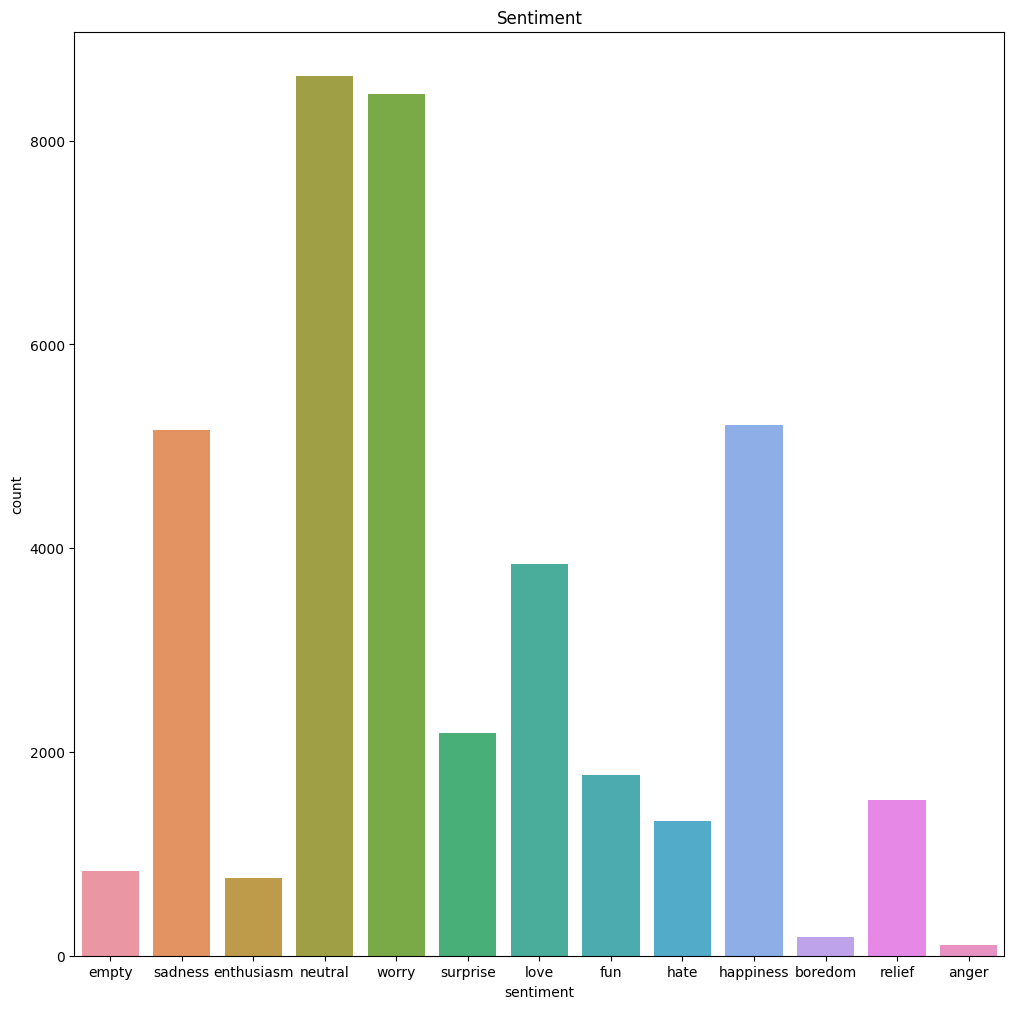

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
sns.countplot(x=df['sentiment'])
plt.title('Sentiment')
plt.show()

In [13]:
df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

Distribusi sentimen menunjukkan bahwa sentimen yang paling umum dalam dataset ini adalah "neutral" dengan 8.638 record. Sebaliknya, sentimen seperti "anger" dengan hanya 110 record, lebih jarang terjadi. Pada tahap preprocessing, dengan mempertimbangkan dampak potensial dari imbalance class, mungkin masuk akal untuk menghapus sentiment dengan record yang sedikit untuk memastikan representasi yang seimbang di seluruh set data.

In [14]:
df['content'][39995]

'@JohnLloydTaylor'

In [15]:
df['sentiment'][39995]

'neutral'

Seperti yang kita lihat, ada record yang hanya berisi @ terhadap seseorang, hal ini akan dihandle pada text preprocessing.

In [16]:
df.duplicated().any()

False

Tidak terdapat duplicate record

## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">Data Preprocessing</p>

Sebelum masuk me data preprocessing, Kami melakukan splitting dataset untuk menghidari terjadinya data leakage.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = df['content']
y = df['sentiment']

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=777)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=777)

Kami menggunakan dataset split 70% training, 15% testing, dan 15% validation.

In [20]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Cleaning

In [21]:
def cleansing(df):
    # Mengubah menjadi lowercase
    df_clean = df.str.lower()

    # Menghapus URL
    df_clean = [re.sub(r'http\S+', '', i) for i in df_clean]

    # Menhapus mention (@random)
    df_clean = [re.sub(r'@[\w_]+', '', i) for i in df_clean]

    # Menghapus hashtag
    df_clean = [re.sub(r'#', '', i) for i in df_clean]

    # Menghapus angka
    df_clean = [re.sub(r'\d+', '', i) for i in df_clean]

    # Menghapus non-word characters 
    df_clean = [re.sub(r'[^\w\s]', ' ', i) for i in df_clean]

    # Menghapus extra whitespaces
    df_clean = [re.sub(r'\s+', ' ', i).strip() for i in df_clean]

    return df_clean

In [22]:
train_clean = cleansing(X_train)
test_clean = cleansing(X_test)
val_clean = cleansing(X_val)

## Tokenization + Stopword Removal + Stemming

In [23]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def process_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return stemmed_tokens

In [24]:
train_processed = [process_text(text) for text in train_clean]
test_processed = [process_text(text) for text in test_clean]
val_processed = [process_text(text) for text in val_clean]

## EDA After Cleaning

In [25]:
val_processed[0:5]

[['gooni', 'project', 'garag', 'door', 'amaz'],
 ['hahaha',
  'sa',
  'una',
  'lang',
  'yan',
  'start',
  'minut',
  'ng',
  'k',
  'year',
  'ago'],
 ['wait', 'amp', 'kati', 'alway', 'end', 'best', 'interview'],
 ['fell', 'think', 'knee', 'broken', 'look', 'fabul'],
 ['best', 'friend', 'go', 'school', 'other', 'chang', 'school']]

In [26]:
test_processed[0:5]

[['um',
  'happi',
  'star',
  'war',
  'day',
  'btw',
  'cheer',
  'scruffi',
  'look',
  'nerfherd',
  'hot',
  'ami'],
 ['pretti', 'janett', 'exact', 'hey', 'monday', 'band', 'arm'],
 ['oh',
  'man',
  'rain',
  'seatbelt',
  'buckl',
  'thank',
  'bate',
  'wish',
  'blow',
  'flip',
  'burn'],
 ['thank', 'followfriday'],
 ['two', 'day', 'comcast', 'technician', 'schedul', 'tomorrow', 'morn']]

## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">Vectorization + Modelling + Experimentation</p>

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

## Baseline Model

Untuk baseline model, Kami menggunakan machine learning model, yaitu Multinomial Logistic Regression, Decision Tree, dan Random Forest.

Menggunakan Tf-IDF

Membuat pipeline agar lebih mudah dalam tahap vectorization, modelling, dan experimentation

In [32]:
def training_tfidf(model, data, target):
    mod = Pipeline([('vect',TfidfVectorizer()),
                   ('clf',model)])
    mod.fit(data,target)
    return mod

## Decision Tree Model

In [33]:
DTree = training_tfidf(DecisionTreeClassifier(random_state = 777), X_train, y_train)
y_pred=DTree.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        17
     boredom       0.00      0.00      0.00        21
       empty       0.06      0.04      0.05       145
  enthusiasm       0.01      0.01      0.01       118
         fun       0.10      0.07      0.09       281
   happiness       0.23      0.24      0.23       776
        hate       0.17      0.12      0.14       203
        love       0.30      0.29      0.29       570
     neutral       0.29      0.36      0.32      1270
      relief       0.07      0.05      0.05       257
     sadness       0.22      0.22      0.22       779
    surprise       0.07      0.06      0.07       326
       worry       0.26      0.28      0.27      1237

    accuracy                           0.23      6000
   macro avg       0.14      0.13      0.13      6000
weighted avg       0.22      0.23      0.23      6000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

## Random Forest Model

In [34]:
RandFor = training_tfidf(RandomForestClassifier(random_state = 777), X_train, y_train)
y_pred=RandFor.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        17
     boredom       0.00      0.00      0.00        21
       empty       0.14      0.01      0.01       145
  enthusiasm       0.00      0.00      0.00       118
         fun       0.12      0.01      0.01       281
   happiness       0.33      0.27      0.29       776
        hate       0.47      0.07      0.13       203
        love       0.50      0.35      0.41       570
     neutral       0.30      0.58      0.40      1270
      relief       0.14      0.01      0.01       257
     sadness       0.34      0.16      0.22       779
    surprise       0.18      0.01      0.02       326
       worry       0.29      0.48      0.36      1237

    accuracy                           0.32      6000
   macro avg       0.22      0.15      0.14      6000
weighted avg       0.30      0.32      0.27      6000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

## Logistic Regression Model

In [35]:
LogReg = training_tfidf(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000), X_train, y_train)
y_pred=LogReg.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        17
     boredom       0.00      0.00      0.00        21
       empty       0.00      0.00      0.00       145
  enthusiasm       0.00      0.00      0.00       118
         fun       0.17      0.02      0.04       281
   happiness       0.34      0.38      0.36       776
        hate       0.42      0.09      0.15       203
        love       0.49      0.37      0.42       570
     neutral       0.35      0.55      0.43      1270
      relief       0.40      0.03      0.06       257
     sadness       0.34      0.25      0.29       779
    surprise       0.29      0.03      0.06       326
       worry       0.32      0.52      0.40      1237

    accuracy                           0.35      6000
   macro avg       0.24      0.17      0.17      6000
weighted avg       0.33      0.35      0.31      6000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">Evaluation</p>